## Import packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
from time import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')
import gc #garbage collector
import scipy.signal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn.utils as nn_utils
import torch.nn.functional as F
from scipy.ndimage import zoom # upscaling
from skimage.measure import block_reduce
from torch.utils.checkpoint import checkpoint
import math
def checkpoint_wrapper(*args, **kwargs):
    def run_function(*args, **kwargs):
        return checkpoint(*args, **kwargs)
    return run_function(*args, use_reentrant=False, **kwargs)

## Synthesize Data

In [3]:
def generate_grf_fft(size, length_scale, variance, seed=42):

    np.random.seed(seed)
    kx = (np.fft.fftfreq(size[0]) * size[0] / length_scale).reshape(-1, 1)
    ky = (np.fft.fftfreq(size[1]) * size[1] / length_scale).reshape(1, -1)
    k_square = kx**2 + ky**2

    power_spectrum = variance * np.exp(-k_square / 2.0)

    white_noise = np.fft.fft2(np.random.randn(*size))

    grf = np.fft.ifft2(white_noise * np.sqrt(power_spectrum)).real
    return grf

size = (64, 64)
length_scale = [10,5]
variance = [1,1]
seed = [42,44]
z1 = generate_grf_fft(size, length_scale[0], variance[0], seed[0])
z2 = generate_grf_fft(size, length_scale[1], variance[1], seed[1])

In [4]:
# Generate z3
def generate_z3(z1, z2, a0, a1, a2, noise_scale, noise_length_scale, seed):
    # Linear combination of z1 and z2
    z3_deterministic = a0 + a1 * z1 + a2 * z2

    # Generate spatial noise
    z3_noise = generate_grf_fft(z1.shape, noise_length_scale, noise_scale**2, seed)

    # Combine deterministic part and noise
    z3 = z3_deterministic + z3_noise

    return z3

# Example usage
a0 = 0
a1 = 0.7  # coefficient for z1's influence
a2 = 0.5  # coefficient for z2's influence
noise_scale = 0.1  # standard deviation of the noise
noise_length_scale = 3  # length scale for the noise GRF
z3_seed = 48

z3 = generate_z3(z1, z2, a0, a1, a2, noise_scale, noise_length_scale, z3_seed)

In [5]:

# plt.figure(figsize=(12, 12))
# for i, z in enumerate([z1, z2, z3]):
#     plt.subplot(1, 3, i+1)
#     plt.imshow(z, cmap='viridis')
#     plt.axis('off')
#     plt.title(f'Z{i+1} GroundTruth')
# plt.tight_layout()
# plt.show();

In [6]:
def euler_maruyama(f, g, z0, T, dt):
    t = torch.arange(0, T+dt, dt)
    num_vars = len(z0)
    shape = z0[0].shape
    z = torch.zeros((len(t), num_vars) + shape)
    z[0, :] = torch.stack(z0)
    for i in range(1, len(t)):
        t_prev = t[i-1]
        for var in range(num_vars):
            z_prev = z[i-1, var]
            dw = torch.randn_like(z_prev) * torch.sqrt(torch.tensor(dt))
            if var == 2:  # Assuming z3 depends on z1 and z2
                z[i, var] = z_prev + f[var](z_prev, z[0,0], z[i-1, 0], z[i-1, 1], t_prev) * dt + g[var](t_prev) * dw
            else:
                z[i, var] = z_prev + f[var](z_prev, z[0,0], t_prev) * dt + g[var](t_prev) * dw
    return t, z





# z1 sde: Ornstein-Uhlenbeck Process
# Define drift and diffusion function


def z1_drift(z, z0, t, omega1=0.1):
    mu = torch.mean(z0) * torch.ones_like(z)
    return omega1 * (mu - z)

def z2_drift(z, z0, t, omega2=0.1):
    mu = torch.mean(z0) * torch.ones_like(z)
    return omega2 * (mu - z)

def z3_drift(z3, z1_t, z2_t, t, omega3=0.1, a1=0.1, a2=0.7, a0=0):
    mu = a0 + a1 * z1_t + a2 * z2_t
    drift = omega3 * (mu - z3)
    return drift


def z1_diffusion(t):
    nu1 = 0.5
    t = torch.tensor(t) if not isinstance(t, torch.Tensor) else t
    return nu1 * torch.ones_like(t)

def z2_diffusion(t):
    nu2 = 0.5
    t = torch.tensor(t) if not isinstance(t, torch.Tensor) else t
    return nu2 * torch.ones_like(t)

def z3_diffusion(t):
    nu3 = 0.5
    t = torch.tensor(t) if not isinstance(t, torch.Tensor) else t
    return nu3 * torch.ones_like(t)



In [7]:
# Parameters
z1_tensor = torch.tensor(z1).float()
z2_tensor = torch.tensor(z2).float()
z3_tensor = torch.tensor(z3).float()

z_t_0 = [z1_tensor, z2_tensor, z3_tensor]

f = [z1_drift, z2_drift, z3_drift]
g = [z1_diffusion, z2_diffusion, z3_diffusion]
T = 1
dt = 0.01

# Run Euler-Maruyama method
t, z = euler_maruyama(f, g, z_t_0, T, dt)


In [8]:
def compare_states(z, compare_index):

    z_initial = z[0]
    z_compare = z[compare_index]


    num_vars = z.shape[1]
    fig, axes = plt.subplots(2, num_vars, figsize=(15, 10))

    for i in range(num_vars):
        ax = axes[0, i]
        im = ax.imshow(z_initial[i], cmap='viridis')
        ax.set_title(f'State of z{i+1} at t={t[0]:.2f}')
        ax.axis('off')

        ax = axes[1, i]
        im = ax.imshow(z_compare[i], cmap='viridis')
        ax.set_title(f'State of z{i+1} at t={t[compare_index]:.2f}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# compare_states(z, len(t)-1)

In [9]:
# Extract intermediate states at specific time points
intermediate_steps = [int(i/dt) for i in [0, 0.5, 1.0]]
z_intermediate = z[intermediate_steps, :]

In [10]:
# Function to generate multi-scale z with different scales for each variable
def generate_multiscale_z(z, scale, noise_level=0.1):
    downsampled = z[::int(1 / scale), ::int(1 / scale)]
    noisy_z = downsampled + np.random.normal(0, noise_level, downsampled.shape)
    return noisy_z

def downsample_area_average(z, scale, noise_level=0.1):
    # Ensure input tensor z is converted to a NumPy array
    if isinstance(z, torch.Tensor):
        z = z.detach().cpu().numpy()  # Convert to NumPy array; ensure it's detached and on CPU

    # Downsample using block_reduce
    block_size = (int(1/scale), int(1/scale))
    downsampled = block_reduce(z, block_size=block_size, func=np.mean)

    # Add noise to the downsampled image
    noisy_z = downsampled + np.random.normal(0, noise_level, downsampled.shape)

    # Convert back to PyTorch tensor if necessary
    noisy_z_tensor = torch.from_numpy(noisy_z).float()

    return noisy_z_tensor

In [11]:
# Define different scales for each variable
scales_z1 = [1, 0.5, 0.15]
scales_z2 = [1, 0.7, 0.25]
scales_z3 = [1, 0.6, 0.2]
scales = [scales_z1, scales_z2, scales_z3]

# Create multi-scale z for intermediate steps
multi_scale_z = []
for i, step in enumerate(z_intermediate):
    # scaled_z1 = generate_multiscale_z(step[0], scale=scales_z1[i])
    # scaled_z2 = generate_multiscale_z(step[1], scale=scales_z2[i])
    # scaled_z3 = generate_multiscale_z(step[2], scale=scales_z3[i])
    scaled_z1 = downsample_area_average(step[0], scale=scales_z1[i])
    scaled_z2 = downsample_area_average(step[1], scale=scales_z2[i])
    scaled_z3 = downsample_area_average(step[2], scale=scales_z3[i])
    multi_scale_z.append([scaled_z1, scaled_z2, scaled_z3])

# # Plot results
# num_time_steps = len(multi_scale_z)
# num_scales = len(multi_scale_z[0])

# fig, axes = plt.subplots(num_scales, num_time_steps, figsize=(10, 10))

# for t_idx, time_step_obs in enumerate(multi_scale_z):
#     for var_idx, var_obs in enumerate(time_step_obs):
#         ax = axes[var_idx, t_idx]
#         scale_value = scales[var_idx][t_idx]
#         ax.imshow(var_obs, cmap='viridis', aspect='auto')
#         ax.set_title(f'Time {t_idx+1}, z{var_idx+1} at scale {scale_value}')
#         ax.axis('off')

# plt.tight_layout()
# plt.show();

# Generate multi-scale observations y condtional on z

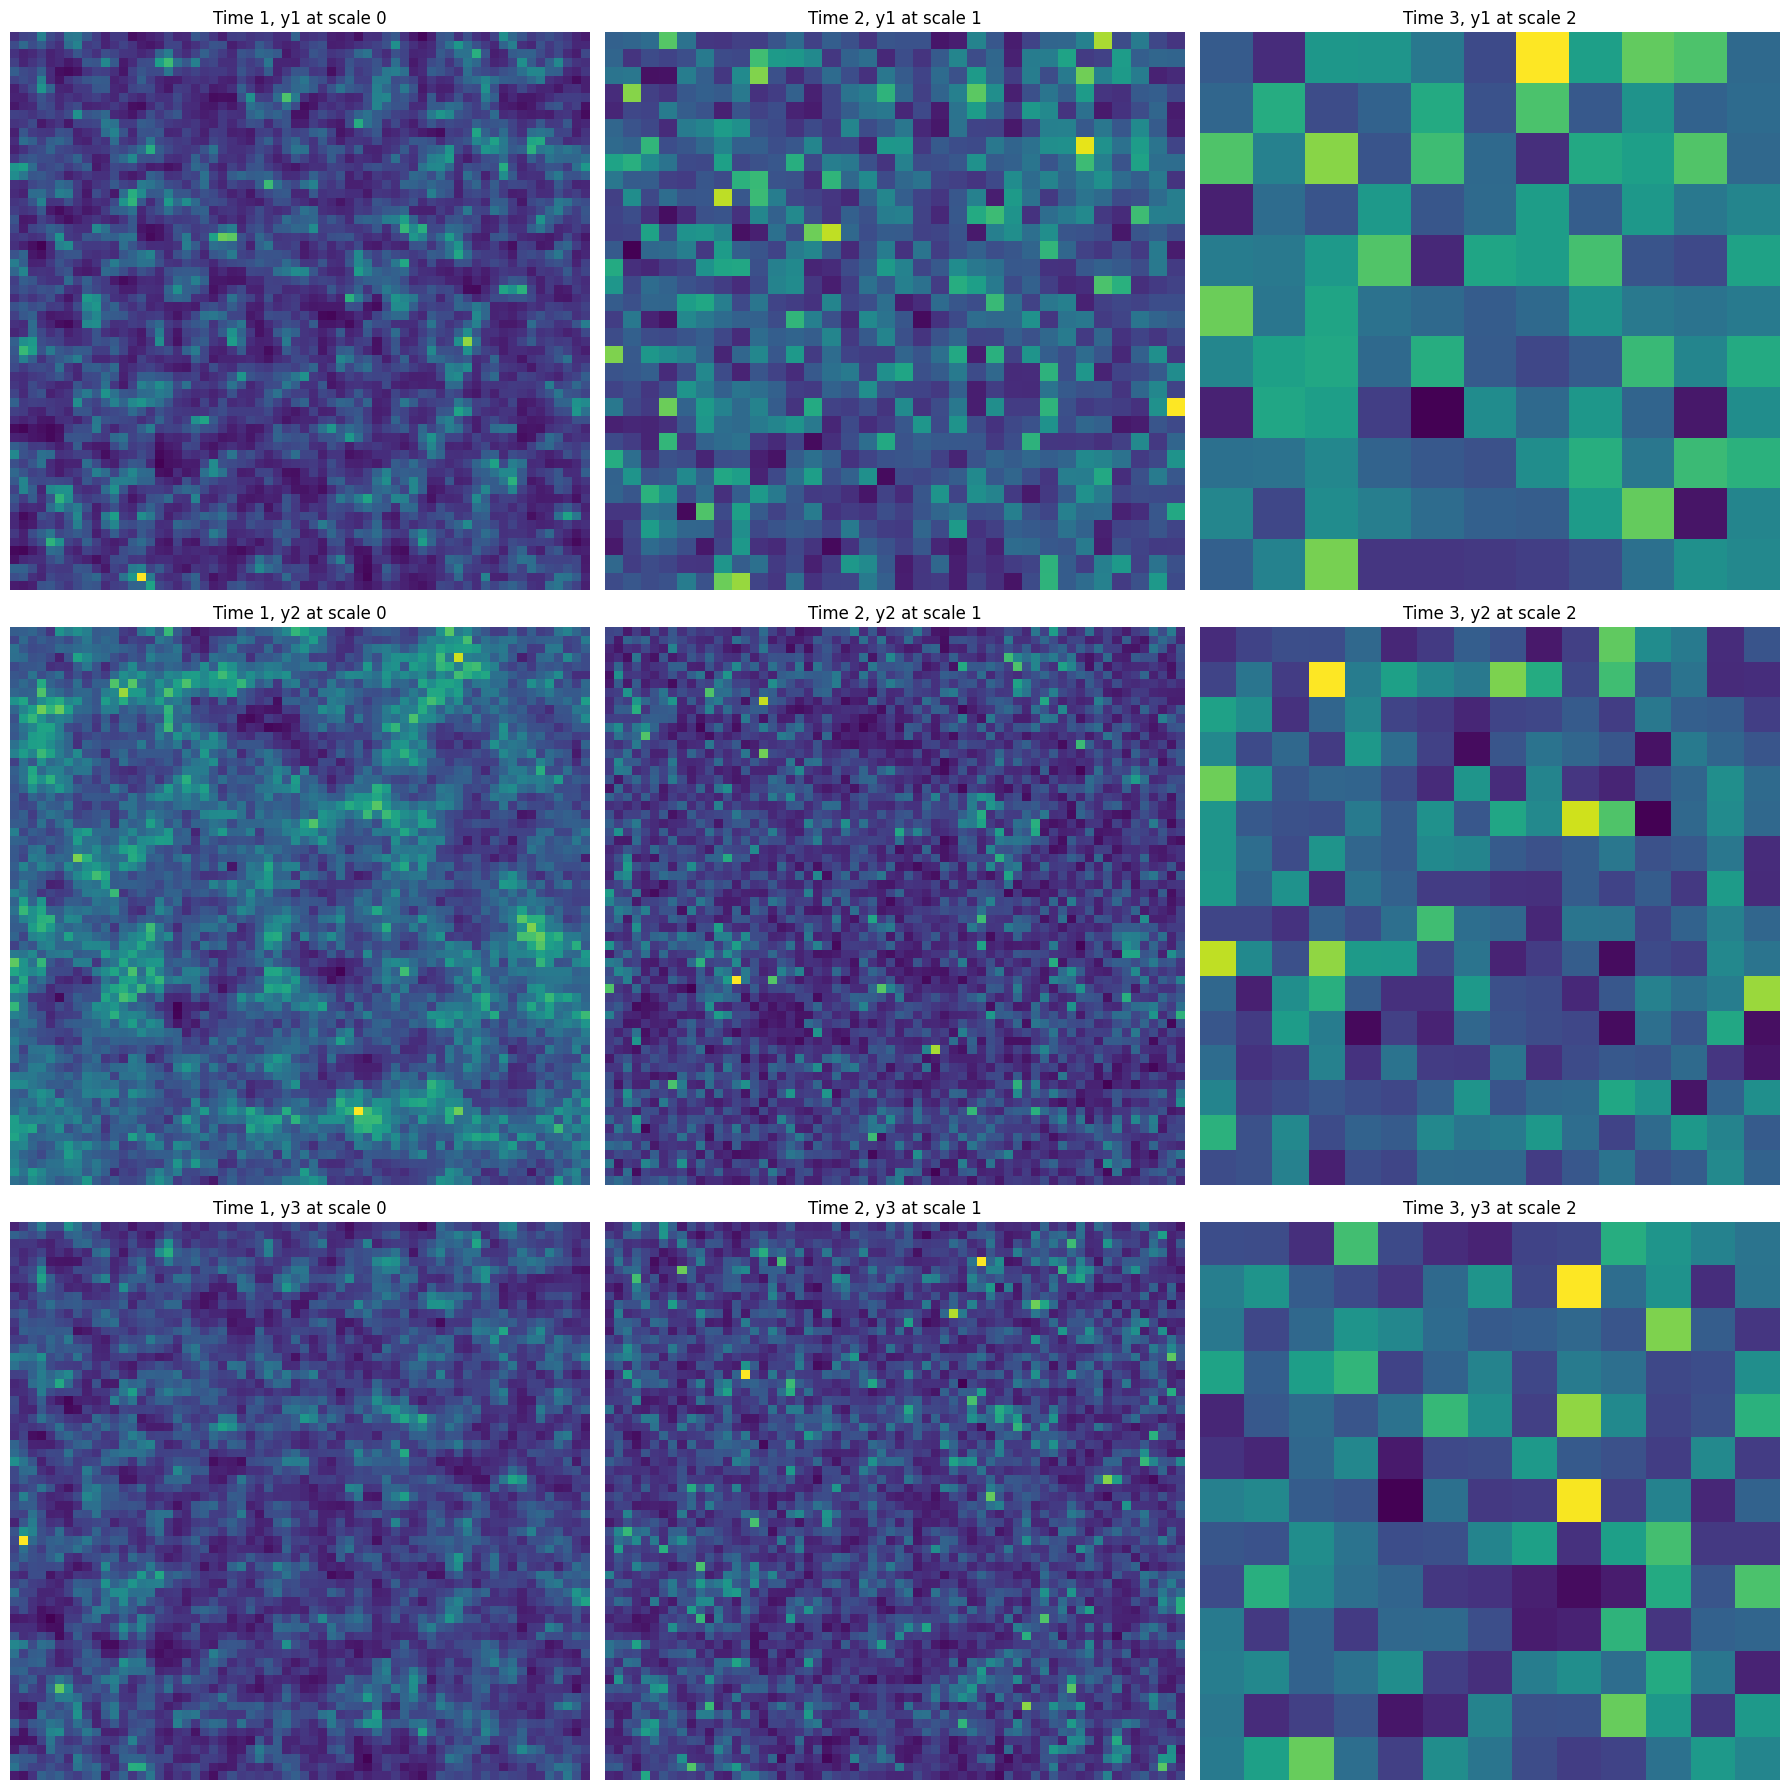

In [14]:
# Function to generate y given z using a log-normal distribution
# mu -> theta0, scale -> theta1，sigma -> eta
def generate_y_given_z(z, theta1=1.0, theta0=0, eta=1):
    log_y_mean = theta0 + theta1 * z
    y = np.exp(log_y_mean + eta * np.random.randn(*log_y_mean.shape))
    return y


# Function to generate multi-scale observations y for given z
def generate_multiscale_y(z_intermediate, scale, noise_level=0.1):
    multi_scale_y = []
    for step in z_intermediate:
        obs_y1 = generate_y_given_z(step[0], theta0=scale[0][i], eta=noise_level)
        obs_y2 = generate_y_given_z(step[1], theta0=scale[1][i], eta=noise_level)
        obs_y3 = generate_y_given_z(step[2], theta0=scale[2][i], eta=noise_level)
        multi_scale_y.append([obs_y1, obs_y2, obs_y3])
    return multi_scale_y

# Define different scales for generating y
scales_y1 = scales_z1  # Matching scales
scales_y2 = scales_z2  # Matching scales
scales_y3 = scales_z3  # Matching scales
scales_y = scales

# Generate multi-scale y observations for intermediate steps
multi_scale_y = generate_multiscale_y(multi_scale_z, scale=scales_y)

# # Plot results for z
num_time_steps = len(multi_scale_z)
num_scales = len(multi_scale_z[0])

# fig1, axes1 = plt.subplots(num_scales, num_time_steps, figsize=(18, 18))

# for t_idx, time_step_obs in enumerate(multi_scale_z):
#     for var_idx, var_obs in enumerate(time_step_obs):
#         ax = axes1[var_idx, t_idx]
#         scale_value = scales[var_idx][t_idx]
#         ax.imshow(var_obs, cmap='viridis', aspect='auto')
#         ax.set_title(f'Time {t_idx+1}, z{var_idx+1} at scale {scale_value}')
#         ax.axis('off')

# plt.tight_layout()
# plt.show()




# # Plot results for y
fig2, axes2 = plt.subplots(num_scales, num_time_steps, figsize=(18, 18))

for t_idx, time_step_obs in enumerate(multi_scale_y):
    for var_idx, var_obs in enumerate(time_step_obs):
        ax = axes2[var_idx, t_idx]
        scale_value = scales[var_idx][t_idx]
        ax.imshow(var_obs, cmap='viridis', aspect='auto')
        ax.set_title(f'Time {t_idx+1}, y{var_idx+1} at scale {t_idx}')
        ax.axis('off')

plt.tight_layout()
plt.show();

# LR observation upscaling

In [14]:
def smooth_upscale_images(images):
    """
    Smoothly upscales a series of images to match the size of the largest image in the input list.
    """
    # Determine the target size (maximum size)
    max_shape = max((img.shape for img in images), key=lambda x: x[0] * x[1])

    # Upscale each image to the target size
    upscaled_images = []
    for img in images:
        # Check if the image is already at maximum size
        if img.shape == max_shape:
            upscaled_images.append(img)  # Directly append the image without scaling
        else:
            scale_factors = [float(max_shape[i]) / img.shape[i] for i in range(len(img.shape))]
            upscaled_img = zoom(img, zoom=scale_factors, order=3)  # order=3 uses cubic spline interpolation
            upscaled_images.append(upscaled_img)

    return upscaled_images

In [15]:
multi_scale_y_upscale = []

for i in range(len(multi_scale_y[0])):
    temp_y = []
    for j in range(len(multi_scale_y)):
        temp_y.append(multi_scale_y[j][i])
    multi_scale_y_upscale.append(smooth_upscale_images(temp_y))

for i in range(len(multi_scale_y_upscale)):
  for j in range(len(multi_scale_y_upscale[i])):
    if not torch.is_tensor(multi_scale_y_upscale[i][j]):
      multi_scale_y_upscale[i][j] = torch.tensor(multi_scale_y_upscale[i][j])




# Experiment



## LearnableParams class

In [18]:
class LearnableParams(nn.Module):
    def __init__(self, initial_values):
        super(LearnableParams, self).__init__()
        for key, value in initial_values.items():
            if isinstance(value, list):
                setattr(self, key, nn.ParameterList([nn.Parameter(torch.tensor(v, dtype=torch.float32)) for v in value]))
            elif isinstance(value, torch.Tensor):
                setattr(self, key, nn.Parameter(value.clone().detach().requires_grad_(True)))
            else:
                setattr(self, key, nn.Parameter(torch.tensor(value, dtype=torch.float32)))

    def get_param(self, name, detach=False):
        param = getattr(self, name)
        if isinstance(param, nn.ParameterList):
            if detach:
                return [p.detach() for p in param]
            return [p for p in param]
        elif detach:
            return param.detach()
        return param

    def get_params_list(self, detach=False):
        params_list = []
        for name, param in self.named_parameters():
            if detach:
                params_list.append(param.detach())
            else:
                params_list.append(param)
        return params_list

    def print_gradients(self):
        for name, param in self.named_parameters():
            if param.grad is not None:
                print(f"Gradient for {name}: {param.grad}")
            else:
                print(f"No gradient for {name} yet")

    def print_requires_grad(self):
        # Print the gradients of all parameters
        for name, param in self.named_parameters():
            if param.grad is not None:
                print(f"Gradient require for {name}: {param.requires_grad}")
            else:
                print(f"Not require gradient for {name} yet")

    def __getattr__(self, name):
        if name == 'retain_grads':
            return self._retain_grads
        elif name == 'ensure_grad_on':
            return self._ensure_grad_on
        else:
            return super().__getattr__(name)

    def _retain_grads(self):
        for param in self.parameters():
            if param.requires_grad:
                param.retain_grad()

    def _ensure_grad_on(self):
        for param in self.parameters():
            param.requires_grad_(True)

## Score Matching

In [20]:
def f(z0, learnable_params):
    def z1_drift_wrapper(z, t):
        omega1 = learnable_params.get_param('omega')[0]
        mu = torch.mean(z0[0]) * torch.ones_like(z)
        return omega1 * (mu - z)

    def z2_drift_wrapper(z, t):
        omega2 = learnable_params.get_param('omega')[1]
        mu = torch.mean(z0[1]) * torch.ones_like(z)
        return omega2 * (mu - z)

    def z3_drift_wrapper(z, t, z1_t, z2_t):
        omega3 = learnable_params.get_param('omega')[2]
        a0 = learnable_params.get_param('a')[0]
        a1 = learnable_params.get_param('a')[1]
        a2 = learnable_params.get_param('a')[2]
        mu = a0 + a1 * z1_t + a2 * z2_t
        return omega3 * (mu - z)

    return [z1_drift_wrapper, z2_drift_wrapper, z3_drift_wrapper]

def g(learnable_params):
    def z1_diffusion_wrapper(t):
        nu1 = learnable_params.get_param('nu')[0]
        return nu1 * torch.ones_like(torch.tensor(t))

    def z2_diffusion_wrapper(t):
        nu2 = learnable_params.get_param('nu')[1]
        return nu2 * torch.ones_like(torch.tensor(t))

    def z3_diffusion_wrapper(t):
        nu3 = learnable_params.get_param('nu')[2]
        return nu3 * torch.ones_like(torch.tensor(t))

    return [z1_diffusion_wrapper, z2_diffusion_wrapper, z3_diffusion_wrapper]


In [21]:
def calculate_mu_step(z0, learnable_params, mus_prev, t_prev, y, theta0, theta1, dt, var_idx, lambda_func):
    f_list = f(z0, learnable_params)

    if var_idx == 2:
        drift = f_list[var_idx](mus_prev[var_idx], t_prev, mus_prev[0], mus_prev[1])
    else:
        drift = f_list[var_idx](mus_prev[var_idx], t_prev)

    drift = drift.reshape(-1)

    lambda_value = lambda_func(t_prev).item() if torch.is_tensor(lambda_func(t_prev)) else lambda_func(t_prev)

    observation_term = lambda_value * ((torch.log(y + 1e-8) - theta0) / theta1 - mus_prev[var_idx])
    return mus_prev[var_idx] + (drift + observation_term) * dt


def calculate_all_mu_elbo(T, z_initial, learnable_params, lambda_func, y_all_obs, theta0, theta1, N = 1000):
    t = torch.linspace(0, T, N+1)
    dt = T / N
    num_vars = len(z_initial)
    mus = [z_initial.clone()]

    for i in range(1, N+1):
        t_prev = t[i-1]
        y_i_idx = int(torch.round(t_prev * (len(y_all_obs[0]) - 1)))

        mus_step = []
        for var_idx in range(num_vars):
            y = torch.tensor(y_all_obs[var_idx][y_i_idx], dtype=torch.float32).reshape(-1)
            theta0_value = theta0[var_idx, y_i_idx].unsqueeze(0) if theta0.dim() > 1 else theta0[var_idx].unsqueeze(0)
            theta1_value = theta1[var_idx, y_i_idx].unsqueeze(0) if theta1.dim() > 1 else theta1[var_idx].unsqueeze(0)

            mu_var = calculate_mu_step(
                z_initial, learnable_params, mus[i-1], t_prev, y,
                theta0_value, theta1_value,
                dt, var_idx, lambda_func
            )
            mus_step.append(mu_var)

        mus.append(torch.stack(mus_step))

    return torch.stack(mus)


def calculate_all_sigma_elbo(T, learnable_params, N=1000, epsilon=1e-6):
    with torch.set_grad_enabled(True):
        t = torch.linspace(0, T, N+1)
        dt = T / N
        num_vars = 3  # Assuming there are three variables z1, z2, z3
        sigmas = [torch.zeros(num_vars)]  # Initialize the first sigma values

        g_list = g(learnable_params)
        for i in range(1, N+1):
            sigmas_step = []
            for var_idx in range(num_vars):
                g_func = g_list[var_idx]
                sigma_var = torch.sqrt(sigmas[i-1][var_idx]**2 + (g_func(t[i])**2) * dt + epsilon)
                sigmas_step.append(sigma_var)
            sigmas.append(torch.stack(sigmas_step))

        return torch.stack(sigmas)



def step_function(z_prev, t_prev, y_i_close, var, z0, learnable_params, y_i_idx, lambda_func, dt):
  with torch.set_grad_enabled(True):
    learnable_params._retain_grads()
    # Ensure all inputs are tensors and on the same device
    device = z_prev.device
    t_prev = torch.tensor(t_prev, device=device)
    dt = torch.tensor(dt, device=device)

    # Use .item() for scalar tensors
    lambda_value = lambda_func(t_prev).item() if torch.is_tensor(lambda_func(t_prev)) else lambda_func(t_prev)

    # Compute log term
    log_term = torch.log(y_i_close + 1e-8)

    # Get f_list and g_list
    f_list = f(z0, learnable_params)
    g_list = g(learnable_params)

    # Get theta for this variable and time step
    theta = learnable_params.get_param("theta")
    theta0 = theta[var, y_i_idx, 0].unsqueeze(0)  # Keep it as a 1D tensor
    theta1 = theta[var, y_i_idx, 1].unsqueeze(0)  # Keep it as a 1D tensor

    if var == 2:  # Assuming z3 depends on z1 and z2
        drift = (f_list[var](z_prev, t_prev, z_prev[0], z_prev[1]) +
                 lambda_value * ((log_term - theta0) / theta1 - z_prev))
    else:
        drift = (f_list[var](z_prev, t_prev) +
                 lambda_value * ((log_term - theta0) / theta1 - z_prev))

    dw = torch.randn_like(z_prev) * torch.sqrt(dt)
    # print(f'drift*dt: {drift * dt}')
    # print(f'random: {g_list[var](t_prev) * dw}')
    return z_prev + drift * dt + g_list[var](t_prev) * dw


def euler_maruyama_forward(prior_i_list, lambda_func, learnable_params, T, dt, train=True, z0=None):
    with torch.set_grad_enabled(True):
        learnable_params.retain_grads()
        t = torch.arange(0, T + dt, dt)
        num_vars = len(prior_i_list)
        shape = prior_i_list[0][0].shape[0]*prior_i_list[0][0].shape[1] #############
        # z = torch.zeros([len(t), num_vars, shape], requires_grad=True)
        # epsilon_standard = torch.zeros([len(t), num_vars, shape], requires_grad=True)
        z = torch.zeros([len(t), num_vars, shape])
        epsilon_standard = torch.zeros([len(t), num_vars, shape])

        # keep sigma at each t
        sigma_0_to_T = torch.zeros([len(t), num_vars])

        # Initialize z[0]
        if train:
            z_0 = torch.stack([torch.log(torch.tensor(prior_i_list[i][0], dtype=torch.float32) + 1e-8) / torch.log(1 - torch.tensor(prior_i_list[i][0], dtype=torch.float32) + 1e-8) for i in range(num_vars)])
            z_0 = z_0.reshape(num_vars,-1)
        else:
            z_0 = z0

        z = torch.cat([z_0.unsqueeze(0), z[1:]], dim=0)

        mus = calculate_all_mu_elbo(T, z_0.reshape(3,-1), learnable_params)
        sigmas = calculate_all_sigma_elbo(T, learnable_params, N=1000, epsilon=1e-6)
        # print(sigmas)
        # print(f'sigmas: {sigmas.requires_grad}')
        # print(f'mus: {mus.requires_grad}')

        for j in range(1, len(t)):
          t_prev = t[j-1]
          mu_sigma_idx = int(t[j] * (mus.shape[0] - 1))
          mu_t = mus[mu_sigma_idx]
          sigma_t = sigmas[mu_sigma_idx]
          sigma_0_to_T[j] = sigmas[mu_sigma_idx]

          z_step = []
          epsilon_step = []

          for var in range(num_vars):
              z_next = step_function(z[j-1], t_prev, var, learnable_params, dt)
              z_step.append(z_next)

              epsilon = (z_next - mu_t[var].reshape(z_next.shape)) / (sigma_t[var]**2 + 1e-8)
              epsilon_step.append(epsilon)

          z_new = torch.stack(z_step)
          epsilon_new = torch.stack(epsilon_step)

          z[j] = z_new
          epsilon_standard[j] = epsilon_new

        z = z.float()
        epsilon_standard = epsilon_standard.float()
        # print(z.requires_grad)
        # print(epsilon_standard.requires_grad)
        # print(f'sigma_0_to_T: {sigma_0_to_T.requires_grad}')
        return t, z, epsilon_standard, sigma_0_to_T

In [22]:
def euler_maruyama_forward(y_i_list, lambda_func, learnable_params, T, dt, mean_sample=None, std_sample=None, sample_only=True, chunk_size=2, train=True, z0=None):
    with torch.set_grad_enabled(True):
        learnable_params.retain_grads()
        t = torch.arange(0, T + dt, dt)
        num_vars = len(y_i_list)
        shape = y_i_list[0][0].shape
        z = torch.zeros((len(t), num_vars) + shape, requires_grad=True)
        epsilon_standard = torch.zeros((len(t), num_vars) + shape, requires_grad=True)
        theta = learnable_params.get_param("theta")
        # print(f'theta: {theta.requires_grad}')

        # keep sigma at each t
        sigma_0_to_T = torch.zeros([len(t), num_vars])

        # Initialize z[0]
        if train:
            z_0 = torch.stack([(torch.log(y_i_list[i][0] + 1e-8) - theta[i, 0, 0].unsqueeze(0)) / theta[i, 0, 1].unsqueeze(0) for i in range(num_vars)])
        else:
            z_0 = z0

        z = torch.cat([z_0.unsqueeze(0), z[1:]], dim=0)

        # mus = calculate_all_mu_elbo(T, z_0.reshape(3,-1), learnable_params, lambda_func, y_i_list, theta[:,:,0], theta[:,:,1], N=1000)
        # sigmas = calculate_all_sigma_elbo(T, learnable_params, N=1000, epsilon=1e-6)
        # print(sigmas)
        # print(f'sigmas: {sigmas.requires_grad}')
        # print(f'mus: {mus.requires_grad}')

        for i in range(1, len(t), chunk_size):
            end_idx = min(i + chunk_size, len(t))
            z_chunk = []
            epsilon_chunk = []

            for j in range(i, end_idx):
                t_prev = t[j-1]
                z_step = []
                epsilon_step = []

                for var in range(num_vars):
                    y_i_idx = int(torch.round(t_prev * (len(y_i_list[var]) - 1)))
                    y_i_close = torch.tensor(y_i_list[var][y_i_idx], dtype=torch.float32)

                    # Use checkpoint to compute each step to save memory
                    z_next = step_function(z[j-1, var], t_prev, y_i_close, var, z_0, learnable_params, y_i_idx, lambda_func, dt)

                    # print(f'z_next: {z_next.requires_grad}')
                    z_step.append(z_next)

                    # epsilon = (z_next - mu_t[var].reshape(z_next.shape)) / (sigma_t[var]**2 + 1e-8)
                    if not sample_only:
                        mu_sigma_idx = int(t[j] * (mean_sample.shape[0] - 1))
                        mu_t = mean_sample[mu_sigma_idx,var]
                        sigma_t = std_sample[mu_sigma_idx,var]
                        sigma_0_to_T[j] = std_sample[mu_sigma_idx,var]
                        epsilon = (z_next - mu_t) / (sigma_t**2 + 1e-8)
                        epsilon_step.append(epsilon)


                z_chunk.append(torch.stack(z_step))
                if not sample_only:
                    epsilon_chunk.append(torch.stack(epsilon_step))

            z_new = torch.stack(z_chunk)
            z = torch.cat([z[:i], z_new, z[end_idx:]], dim=0)
            if not sample_only:
                epsilon_new = torch.stack(epsilon_chunk)
                epsilon_standard = torch.cat([epsilon_standard[:i], epsilon_new, epsilon_standard[end_idx:]], dim=0)
            # z.detach()
            # epsilon_standard.detach()
            # print(f'z: {z.requires_grad}')
            # print(f'epsilon_standard: {epsilon_standard.requires_grad}')
            # learnable_params.print_requires_grad()
        z = z.float()
        epsilon_standard = epsilon_standard.float()
        # print(sigma_0_to_T.requires_grad)
        if not sample_only:
            return t, z, epsilon_standard, sigma_0_to_T
        else:
            return t, z

In [24]:
# def euler_maruyama_forward(y_i_list, lambda_func, learnable_params, T, dt, mean_sample=None, std_sample=None, sample_only=True, train=True, z0=None):
#     with torch.set_grad_enabled(True):
#         learnable_params.retain_grads()
#         t = torch.arange(0, T + dt, dt)
#         num_vars = len(y_i_list)
#         shape = y_i_list[0][0].shape
#         z = torch.zeros((len(t), num_vars) + shape, requires_grad=True)
#         epsilon_standard = torch.zeros((len(t), num_vars) + shape, requires_grad=True)
#         theta = learnable_params.get_param("theta")

#         # keep sigma at each t
#         sigma_0_to_T = torch.zeros([len(t), num_vars])

#         # Initialize z[0]
#         if train:
#             z_0 = torch.stack([(torch.log(y_i_list[i][0] + 1e-8) - theta[i, 0, 0].unsqueeze(0)) / theta[i, 0, 1].unsqueeze(0) for i in range(num_vars)])
#         else:
#             z_0 = z0

#         z[0] = z_0

#         for j in range(1, len(t)):
#             t_prev = t[j-1]

#             for var in range(num_vars):
#                 y_i_idx = int(torch.round(t_prev * (len(y_i_list[var]) - 1)))
#                 y_i_close = torch.tensor(y_i_list[var][y_i_idx], dtype=torch.float32)

#                 # Compute each step
#                 z[j, var] = step_function(z[j-1], t_prev, y_i_close, var, z_0, learnable_params, y_i_idx, lambda_func, dt)

#                 if not sample_only:
#                     mu_sigma_idx = int(t[j] * (mean_sample.shape[0] - 1))
#                     mu_t = mean_sample[mu_sigma_idx, var]
#                     sigma_t = std_sample[mu_sigma_idx, var]
#                     sigma_0_to_T[j, var] = std_sample[mu_sigma_idx, var]
#                     epsilon_standard[j, var] = (z[j, var] - mu_t) / (sigma_t**2 + 1e-8)

#         z = z.float()
#         epsilon_standard = epsilon_standard.float()

#         if not sample_only:
#             return t, z, epsilon_standard, sigma_0_to_T
#         else:
#             return t, z

In [25]:
# # Function to initialize parameters
# def initialize_parameter(shape, mean=0.0, std=0.1, distribution='normal', upper=1.0):
#     if distribution == 'normal':
#         tensor = torch.normal(mean, std, shape)
#     elif distribution == 'uniform':
#         tensor = torch.rand(shape)*upper
#     tensor = torch.abs(tensor)
#     tensor.requires_grad = True
#     return tensor

# # Set initial values using the function
# initial_values = {
#     'mu': initialize_parameter((2,), mean=0.0, std=0.1),
#     'a': torch.tensor([0.33, 0.33, 0.34], requires_grad=True),
#     'sigma': initialize_parameter((3,), distribution='uniform'),
#     'omega': initialize_parameter((3,), distribution='uniform',upper=0.01),
#     'nu': 0.5 + initialize_parameter((3,), distribution='uniform',upper=0.1),
#     'theta': initialize_parameter((3, 3, 2)),
#     'eta': initialize_parameter((3, 3, 1), distribution='uniform',upper=0.01)
# }

# # Ensure 'a' sums to 1
# initial_values['a'] = initial_values['a'] / initial_values['a'].sum()

# # Clip values to ensure stability
# for key in ['sigma', 'omega', 'nu', 'eta']:
#     initial_values[key] = torch.clamp(initial_values[key], min=1e-5, max=10)

# learnable_params = LearnableParams(initial_values)

# def init_weights(m):
#     if type(m) == nn.Linear or type(m) == nn.Conv2d:
#         nn.init.xavier_uniform_(m.weight)
#         nn.init.constant_(m.bias, 0)
# score_nets = [ScoreNetZ1(), ScoreNetZ2(), ScoreNetZ3()]
# for net in score_nets:
#     net.apply(init_weights)

# path_num = 10
# path = torch.zeros(path_num, 101, 3, 64, 64)
# dt = 0.01
# lambda_func = lambda s: 0.01
# for i in range(path_num):
#   t, z, epsilon_standard, sigma_0_to_T = euler_maruyama_forward(multi_scale_y_upscale,lambda_func, learnable_params, T, dt)
#   path[i] = z
#   print(i)

In [26]:
# mean_sample = torch.mean(path, dim=0)
# std_sample = torch.std(path, dim=(0,3,4))
# t, z, epsilon_standard, sigma_0_to_T = euler_maruyama_forward(multi_scale_y_upscale, lambda_func, learnable_params, T, dt, mean_sample, std_sample, sample_only=False)
# scorenet_loss = 0
# for i in range(1,t.shape[0]):

#     t = t[i].expand(z.shape[2]*z.shape[3])  # Expand t to match batch size
#     sigma_at_t = std_sample[i]
#     # print(f'sigma_at_t: {sigma_at_t}')

#     # Calculate loss for the mini-batch
#     batch_loss_t = training_step(score_nets, t, z[i], epsilon_standard[i],sigma_at_t)
#     scorenet_loss += batch_loss_t
#     if not torch.isfinite(batch_loss_t):
#         print(f"Non-finite loss detected: {batch_loss_t.item()}")
#         continue
# print(scorenet_loss)


In [28]:
class ScoreNetZ1(nn.Module):
    def __init__(self):
        super(ScoreNetZ1, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, z, t):
        z = z.detach().requires_grad_(True)  # Detach and set requires_grad to True
        z = z.view(-1, 1)
        t = t.view(-1, 1)
        x = torch.cat([z, t], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        score = self.fc3(x).squeeze(-1)
        score_grad = torch.autograd.grad(score.sum(), z, create_graph=True)[0]
        return score, score_grad

class ScoreNetZ2(nn.Module):
    def __init__(self):
        super(ScoreNetZ2, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, z, t):
        z = z.detach().requires_grad_(True)
        z = z.view(-1, 1)
        t = t.view(-1, 1)
        x = torch.cat([z, t], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        score = self.fc3(x).squeeze(-1)
        score_grad = torch.autograd.grad(score.sum(), z, create_graph=True)[0]
        return score, score_grad

class ScoreNetZ3(nn.Module):
    def __init__(self):
        super(ScoreNetZ3, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, z, z1, z2, t):
        z = z.detach().requires_grad_(True)  # Detach and set requires_grad to True
        z = z.view(-1, 1)
        z1 = z1.view(-1, 1)
        z2 = z2.view(-1, 1)
        t = t.view(-1, 1)
        x = torch.cat([z, z1, z2, t], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        score = self.fc3(x).squeeze(-1)
        score_grad = torch.autograd.grad(score.sum(), z, create_graph=True)[0]
        return score, score_grad




In [29]:
def training_step(score_nets, t, z_forward, epsilon_forward, sigma_at_t):
    t = torch.tensor(t) if not isinstance(t, torch.Tensor) else t
    batch_samples = z_forward.shape[1]
    avg_loss = 0
    for var_idx, score_net in enumerate(score_nets):
        z_t = z_forward[var_idx]
        z_t_flat = z_t.reshape(-1)
        epsilon_flat = epsilon_forward[var_idx].reshape(-1)
        # Check epsilon distribution
        # print(f"Epsilon mean for var {var_idx}: {epsilon_flat.mean().item()}, std: {epsilon_flat.std().item()}")
        if var_idx == 2:  # For ScoreNetZ3
            z1_t_batch = z_forward[0].reshape(-1)
            z2_t_batch = z_forward[1].reshape(-1)
            s_theta, _ = score_net(z_t_flat, z1_t_batch, z2_t_batch, t)
        else:  # For ScoreNetZ1 and ScoreNetZ2
            s_theta, _ = score_net(z_t_flat, t)
        gamma_t = 1 / (1 + t[0])
        # print(f'score max:{torch.max(s_theta)}')
        # print(f'epsilon max:{torch.max(torch.abs(epsilon_flat))}')
        # print(f'diff max:{torch.max((s_theta+epsilon_flat)**2)}')
        # print(f'diff min:{torch.min((s_theta+epsilon_flat)**2)}')
        batch_loss_var = gamma_t * (sigma_at_t[var_idx]**2) *torch.sqrt(F.mse_loss(s_theta, -epsilon_flat))
        if torch.isnan(batch_loss_var) or torch.isinf(batch_loss_var):
            continue
        # Scale the loss
        scaled_loss = batch_loss_var #/ (z_t_flat.std() + 1e-8)
        avg_loss += scaled_loss
    return torch.clamp(avg_loss, max=1e6)

## ELBO Loss

In [30]:
def log_sum_exp(x, dim=0):
    max_x = torch.max(x, dim=dim)[0]
    return max_x + torch.log(torch.sum(torch.exp(x - max_x.unsqueeze(dim)), dim=dim))

def stabilize_variance(sigma):
    return torch.log(sigma**2 + 1)

def log_likelihood(y_i, t_list, zi_t_mean, zi_t_std, theta_0_i, theta_1_i, eta_i):
  with torch.autograd.grad_mode.enable_grad():
    learnable_params.retain_grads()
    min_sigma = 1e-5
    log_probs = []
    for j, (t, y) in enumerate(zip(t_list, y_i)):
        if isinstance(y, np.ndarray):
            y = torch.tensor(y, dtype=torch.float32)
        y = y.reshape(-1)
        # print(theta_0_i[j].shape)
        mean = theta_0_i[j] + theta_1_i[j] * zi_t_mean[j]
        sigma = torch.sqrt(theta_1_i[j]**2 * zi_t_std[j]**2 + eta_i[j]**2)
        sigma = torch.clamp(sigma, min=min_sigma)

        stable_sigma = stabilize_variance(sigma)

        diff = torch.log(y) - mean
        log_prob = -0.5 * (diff**2 / torch.exp(stable_sigma) + stable_sigma + np.log(2 * np.pi)) - torch.log(y)
        log_probs.append(log_sum_exp(log_prob))

    total_log_prob_i = torch.sum(torch.stack(log_probs))
    return total_log_prob_i

def compute_prior(z1_reverse, z2_reverse, z3_reverse, mu1, mu2, sigma1, sigma2, a0, a1, a2, sigma3):
    learnable_params.retain_grads()
    def log_normal_pdf(x, mean, std):
        min_std = 1e-5
        std = torch.clamp(std, min=min_std)
        return -0.5 * (torch.log(2 * np.pi * std**2) + ((x - mean) / std)**2)

    log_p_z1 = log_normal_pdf(z1_reverse, mu1, sigma1)
    log_p_z2 = log_normal_pdf(z2_reverse, mu2, sigma2)
    mu3 = a0 + a1 * z1_reverse + a2 * z2_reverse
    log_p_z3_given_z1_z2 = log_normal_pdf(z3_reverse, mu3, sigma3)
    # print("log_sum_exp: ",log_sum_exp(log_p_z1 + log_p_z2 + log_p_z3_given_z1_z2, dim=0))
    # print(f'log_sum_exp(log_p_z1 + log_p_z2 + log_p_z3_given_z1_z2, dim=0):{(log_sum_exp(log_p_z1 + log_p_z2 + log_p_z3_given_z1_z2, dim=0)).requires_grad}')
    return log_sum_exp(log_p_z1 + log_p_z2 + log_p_z3_given_z1_z2, dim=0)

def log_kde(zi_reverse, zi_reverse_samples, h=None):
    learnable_params.retain_grads()
    if h is None:
        n, d = zi_reverse_samples.shape
        h = n**(-1./(d+4))  # Scott's rule

    zi_reverse = zi_reverse.unsqueeze(0)
    # print(f'zi_reverse:{(zi_reverse).requires_grad}')
    # print(f'zi_reverse_samples: {(zi_reverse_samples).requires_grad}')
    zi_reverse_samples = zi_reverse_samples.squeeze(1)

    u = (zi_reverse - zi_reverse_samples) / h
    k = torch.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)

    density = torch.sum(k, dim=0) / (zi_reverse_samples.size(0) * h)
    log_kde_posterior_density = torch.log(density + 1e-8)
    # print("log_kde_posterior_density: ", log_kde_posterior_density)
    # print(f'log_sum_exp(log_kde_posterior_density): {(log_sum_exp(log_kde_posterior_density)).requires_grad}')
    return log_sum_exp(log_kde_posterior_density)

def calculate_average_elbo(zi_reverse_samples_list, y_i_list, t_list, lambda_func, learnable_params, mean_sample, std_sample, T=1, h=None, chunk_size=10):
  # torch.autograd.set_detect_anomaly(True)
  with torch.set_grad_enabled(True):
    learnable_params.retain_grads()
    M = zi_reverse_samples_list.size(0)  # Number of reverse samples
    total_elbo = 0

    # Process reverse samples in chunks
    for chunk_start in range(0, M, chunk_size):
        chunk_end = min(chunk_start + chunk_size, M)
        chunk_elbos = []

        for m in range(chunk_start, chunk_end):
            elbo_m = 0
            chunk_elbo = 0

            # Compute the prior term
            z1_reverse, z2_reverse, z3_reverse = zi_reverse_samples_list[m]
            log_prior_val = compute_prior(
                z1_reverse, z2_reverse, z3_reverse,
                learnable_params.get_param("mu")[0], learnable_params.get_param("mu")[1],
                learnable_params.get_param("sigma")[0], learnable_params.get_param("sigma")[1],
                learnable_params.get_param("a")[0], learnable_params.get_param("a")[1], learnable_params.get_param("a")[2],
                learnable_params.get_param("sigma")[2]
            )

            # Compute mus and sigmas using checkpointing
            mus = mean_sample
            sigmas = std_sample

            # Extract mean and variance of z1(t), z2(t), z3(t)
            mean = []
            std = []
            for var_idx in range(3):
                mean_var = []
                std_var = []
                for t in t_list[var_idx]:
                    mu_sigma_idx = int(t * (mus.shape[0] - 1))
                    mean_var.append(mus[mu_sigma_idx, var_idx])
                    std_var.append(sigmas[mu_sigma_idx, var_idx])
                mean.append(torch.stack(mean_var))
                std.append(torch.stack(std_var))

            log_likelihood_print = 0
            log_kde_print = 0
            # Iterate over each variable z1, z2, z3
            for var_idx in range(3):
                zi_reverse = zi_reverse_samples_list[m, var_idx]
                y_i = y_i_list[var_idx]
                t = t_list[var_idx]

                # Compute log likelihood and KDE using checkpointing
                # log_likelihood_val = checkpoint(log_likelihood, y_i, t_list, mean[var_idx], std[var_idx],
                #                                 learnable_params.get_param("theta")[var_idx, :, 0],
                #                                 learnable_params.get_param("theta")[var_idx, :, 1],
                #                                 learnable_params.get_param("eta")[var_idx])
                log_likelihood_val = log_likelihood(y_i, t_list, mean[var_idx], std[var_idx],
                                    learnable_params.get_param("theta")[var_idx, :, 0],
                                    learnable_params.get_param("theta")[var_idx, :, 1],
                                    learnable_params.get_param("eta")[var_idx])

                log_kde_val = checkpoint(log_kde, zi_reverse, zi_reverse_samples_list[:, var_idx])
                log_likelihood_print += log_likelihood_val
                log_kde_print += log_kde_val

                elbo_m += log_likelihood_val
                elbo_m -= log_kde_val
            # print(f'log_likelihood: {log_likelihood_print}')
            # print(f'log_kde_val: {log_kde_print})')
            # print(f'log_prior_val: {log_prior_val}')
            elbo_m += log_prior_val
            chunk_elbo += elbo_m

        # Accumulate chunk ELBO without detaching
        chunk_elbos.append(chunk_elbo)
        # torch.cuda.empty_cache()  # Free up GPU memory if using CUDA

        # print(f'Chunk {chunk_start//chunk_size + 1} average ELBO: {chunk_elbo.item()/chunk_size:.6f}')

    # Calculate the average ELBO
    total_elbo = torch.stack(chunk_elbos).sum()
    average_elbo = total_elbo / M
    return average_elbo

## Conditional score and reverse E-M path

In [32]:
def calculate_conditional_score(z3, z1, z2, t, z0, score_net_z3, learnable_params, f_list, g_list, y_obs, y_t_idx, mu_t, sigma_t):
    '''Note: the z1, z2, z3 in the input should be result of forward process at time t, not reverse process.'''
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        if len(z3.shape)==2:
            z3 = z3.reshape(-1)
            z2 = z2.reshape(-1)
            z1 = z1.reshape(-1)
        batch_size = z3.shape[0]

        z0 = z0.reshape(3,-1)

        # Get parameters from learnable_params
        mu1 = learnable_params.get_param("mu")[0].expand(batch_size)
        mu2 = learnable_params.get_param("mu")[1].expand(batch_size)
        sigma1 = learnable_params.get_param("sigma")[0].expand(batch_size)
        sigma2 = learnable_params.get_param("sigma")[1].expand(batch_size)
        sigma3 = learnable_params.get_param("sigma")[2].expand(batch_size)
        a0 = learnable_params.get_param("a")[0].expand(batch_size)
        a1 = learnable_params.get_param("a")[1].expand(batch_size)
        a2 = learnable_params.get_param("a")[2].expand(batch_size)
        theta = learnable_params.get_param("theta")

        # Calculate μc and Σc
        denominator = a1**2 * sigma1**2 + a2**2 * sigma2**2 + sigma3**2
        a_sigma_squared = torch.stack([a1 * sigma1**2, a2 * sigma2**2], dim=-1).unsqueeze(2)  # [n, 2, 1]
        vector = (z3 - a0 - a1 * mu1 - a2 * mu2).unsqueeze(1)  # [n, 1]
        adjusted_mu = torch.stack([mu1, mu2], dim=-1)   # [n, 2]
        complex_matrix = (1 / denominator).unsqueeze(1).unsqueeze(2) * a_sigma_squared # [n,2,1]
        mu_c = adjusted_mu + (complex_matrix * vector.view(batch_size, 1, 1)).squeeze(2)   # [n, 2]

        e1 = torch.diag_embed(torch.stack([sigma1, sigma2], dim=-1)) # [n,2,2]
        a_sigma_matrix = torch.stack([a1 * sigma1**2, a2 * sigma2**2], dim=1).unsqueeze(-1)
        sigma_matrix = torch.matmul(a_sigma_matrix, a_sigma_matrix.transpose(1, 2))
        e2 = sigma_matrix / denominator.view(batch_size, 1, 1)
        Sigma_c = e1-e2

        # Calculate ẑ3 using Tweedie's formula
        z3.requires_grad_(True)
        score, _ = score_net_z3(z3, z1, z2, t.expand(batch_size))

        z3_hat = z3 + sigma_t**2 * score / mu_t

        # Calculate the gradient,[n]
        grad = torch.autograd.grad(z3_hat.sum(), z3, create_graph=True)[0]

        # Calculate the second term of conditional score
        z_stack = torch.stack([z1, z2], dim=1)  # Combine z1 and z2 into [n, 2]
        diff = z_stack - mu_c  # [n, 2]

        Sigma_c_inv = torch.linalg.inv(Sigma_c)  # [n, 2, 2]
        mult_step_2 = torch.bmm(Sigma_c_inv, diff.unsqueeze(2))  # [n, 2, 1]

        mult_step_3 = torch.bmm(mult_step_2.transpose(1, 2), complex_matrix)  # [n, 1, 1]

        final_result = mult_step_3.squeeze(2) * grad.unsqueeze(1)  # [n, 1]

        final_result = final_result.squeeze(1) + score # [n]


        return final_result

In [33]:
def score_for_reverse(z_path, t_path, score_nets, y_i_list, learnable_params, lambda_func, mean_sample, std_sample, T=1):
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        # Reverse and reshape the time and corresponding z_path for reverse integration
        t = torch.flip(t_path, [0])
        z_path_reversed = torch.flip(z_path, [0])
        z_path_reversed = z_path_reversed.view(len(t), 3, -1)

        num_vars = z_path.size(1)
        score_given_by_forward = torch.zeros_like(z_path_reversed)  # reverse result

        f_list = f(z_path[0, :], learnable_params)
        g_list = g(learnable_params)

        theta = learnable_params.get_param("theta")
        mus = mean_sample
        sigmas = std_sample

        mus = torch.flip(mus, [0])
        stds = torch.flip(sigmas, [0])

        for i in range(1, len(t)):
            t_prev = t[i-1]
            for var in range(num_vars):
                y_i = y_i_list[var]
                y_i_idx = int(torch.round(t_prev * (len(y_i) - 1)))
                y_i_close = torch.tensor(y_i[y_i_idx], dtype=torch.float32).reshape(-1)

                # Score computation for variable 'var' at previous time
                mu_sigma_idx = int(t[j] * (mean_sample.shape[0] - 1))
                mu_t = mean_sample[mu_sigma_idx,var]
                sigma_t = std_sample[mu_sigma_idx,var]
                if var == 2:
                    conditional_score = calculate_conditional_score(
                        z3=z_path_reversed[i-1, var, :], z1=z_path_reversed[i-1, 0, :],
                        z2=z_path_reversed[i-1, 1, :], t=t_prev, z0=z_path[0, :],
                        score_net_z3=score_nets[var], learnable_params=learnable_params,
                        f_list=f_list, g_list=g_list, y_obs=y_i_close, y_t_idx=y_i_idx,
                        mu_t=mu_t, sigma_t=sigma_t
                    )
                    score_given_by_forward[i, var] = conditional_score
                else:
                    score, _ = score_nets[var](z_path_reversed[i-1, var, :], t[i].expand(z_path_reversed[i, var, :].shape[-1]))
                    score_given_by_forward[i, var] = score

        return score_given_by_forward

def drift_diffusion_wrapper(f_list, g_list, z_prev, t_prev, z1, z2, y_i_close, theta, lambda_func, var_idx):
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        drift = f_list[var_idx](z_prev, t_prev, z1, z2) if var_idx == 2 else f_list[var_idx](z_prev, t_prev)
        diffusion = g_list[var_idx](t_prev)
    return drift, diffusion

def drift_diffusion_step(z_prev, t_prev, y_i_close, var, learnable_params, lambda_func, dt, score):
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        t_prev = torch.tensor(t_prev)
        dt = torch.tensor(dt)

        f_list = f(z_prev, learnable_params)
        g_list = g(learnable_params)
        theta = learnable_params.get_param("theta")

        lambda_value = lambda_func(t_prev).item() if torch.is_tensor(lambda_func(t_prev)) else lambda_func(t_prev)

        log_term = torch.log(y_i_close + 1e-8)

        if var == 2:
            drift = (f_list[var](z_prev, t_prev, z_prev[0], z_prev[1]) +
                     lambda_value * ((log_term - theta[var, 0, 0].unsqueeze(0)) / theta[var, 0, 1].unsqueeze(0) - z_prev))
        else:
            drift = (f_list[var](z_prev, t_prev) +
                     lambda_value * ((log_term - theta[var, 0, 0].unsqueeze(0)) / theta[var, 0, 1].unsqueeze(0) - z_prev))

        diffusion = g_list[var](t_prev)

        res = drift - diffusion**2 * score

    return res, diffusion

# def euler_maruyama_reverse(z_path, t_path, score_given_by_forward, y_i_list, lambda_func, learnable_params, dt, chunk_size=2):
#     with torch.set_grad_enabled(True):
#         t = torch.flip(t_path, [0])
#         z_path_reversed = torch.flip(z_path, [0])
#         z_path_reversed = z_path_reversed.view(len(t), 3, -1)

#         num_vars = z_path.size(1)
#         z = torch.zeros_like(z_path_reversed)
#         z[0, :] = z_path_reversed[0, :]

#         for i in range(1, len(t), chunk_size):
#             end_idx = min(i + chunk_size, len(t))

#             for j in range(i, end_idx):
#                 t_prev = t[j-1]

#                 for var in range(num_vars):
#                     y_i = y_i_list[var]
#                     y_i_idx = int(torch.round(t_prev * (len(y_i) - 1)))
#                     y_i_close = torch.tensor(y_i[y_i_idx], dtype=torch.float32).reshape(-1)
#                     z_prev = z[j-1, var, :]

#                     score = score_given_by_forward[j-1, var]

#                     drift, diffusion = checkpoint(
#                         drift_diffusion_step,
#                         z_prev, t_prev, y_i_close, var, learnable_params, lambda_func, dt, score
#                     )

#                     dw = torch.randn_like(z_prev) * torch.sqrt(torch.tensor(dt))
#                     z[j, var] = z_prev - drift * dt + diffusion * dw
#                     # print(f'diffusion:{diffusion.requires_grad}')
#                     # print(f'z:{z.requires_grad}')
#                     # z_sum = torch.sum(z)
#                     # loss = z_sum**2
#                     # loss.backward()
#                     # learnable_params.print_gradients()
#             z = z.detach()
#             learnable_params.print_gradients()

#         z = torch.flip(z, [0])
#         return z[0]

def euler_maruyama_reverse(z_path, t_path, score_given_by_forward, y_i_list, lambda_func, learnable_params, dt, chunk_size=2):
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        t = torch.flip(t_path, [0])
        z_path_reversed = torch.flip(z_path, [0])
        z_path_reversed = z_path_reversed.view(len(t), 3, -1)

        num_vars = z_path.size(1)
        z = z_path_reversed[0].clone().requires_grad_(True)

        for i in range(1, len(t), chunk_size):
            end_idx = min(i + chunk_size, len(t))

            for j in range(i, end_idx):
                t_prev = t[j-1]
                z_step = []

                for var in range(num_vars):
                    y_i = y_i_list[var]
                    y_i_idx = int(torch.round(t_prev * (len(y_i) - 1)))
                    y_i_close = torch.tensor(y_i[y_i_idx], dtype=torch.float32).reshape(-1)
                    z_prev = z[var]

                    score = score_given_by_forward[j-1, var]

                    drift, diffusion = drift_diffusion_step(
                        z_prev, t_prev, y_i_close, var, learnable_params, lambda_func, dt, score
                    )
                    dw = torch.randn_like(z_prev) * torch.sqrt(torch.tensor(dt))
                    z_next = z_prev - drift * dt + diffusion * dw
                    z_step.append(z_next)

                z = torch.stack(z_step)

        # # Compute loss for this chunk
        # loss_chunk = torch.sum(z**2)
        # loss_chunk.backward()

        # print(f"Gradients after chunk {i}:")
        # learnable_params.print_gradients()

        return z

## Joint Train

In [35]:
def train(score_nets, learnable_params, optimizer, path_epochs, M, f, g, lambda_func, multi_scale_y, y_obs_time, N, T, dt, batch_size=5000):

    num_pixels = multi_scale_y[0][0].shape[0]*multi_scale_y[0][0].shape[1]

    for path_epoch in range(path_epochs):
        print("Epoch: ", path_epoch)

        # Randomize pixels before processing batches
        random_indices = torch.randperm(num_pixels)

        # Iterate over pixels in batches
        for start in range(0, num_pixels, batch_size):

            optimizer.zero_grad()
            total_loss = 0

            end = min(start + batch_size, num_pixels)
            batch_indices = random_indices[start:end]  # Get randomized slice for the current batch
            extracted_multi_scale_y = [[scale.flatten()[batch_indices] for scale in var_array] for var_array in multi_scale_y]

            # Forward for mean and std at t
            path_num = 10
            path = torch.zeros(path_num, 101, 3, end-start)
            for i in range(path_num):
                t, z = euler_maruyama_forward(extracted_multi_scale_y,lambda_func, learnable_params, T=1, dt=0.01)
                path[i] = z
            mean_sample = torch.mean(path, dim=0)
            std_sample = torch.std(path, dim=(0,3))

            # Forward simulation
            t_batch_forward, z_batch_forward, epsilon_batch_forward, sigma_0_to_T = euler_maruyama_forward(extracted_multi_scale_y, lambda_func, learnable_params, T, dt, mean_sample, std_sample, sample_only=False)
            print('Forward simulation finished')
            # print('Forward grad')
            # learnable_params.print_gradients()

            # Process each time step for the current batch
            scorenet_loss = 0
            for i in range(1,t_batch_forward.shape[0]):

                t_batch = t_batch_forward[i].expand(z_batch_forward.shape[2])  # Expand t to match batch size
                sigma_at_t = sigma_0_to_T[i]
                # print(f'sigma_at_t: {sigma_at_t}')

                # Calculate loss for the mini-batch
                batch_loss_t = training_step(score_nets, t_batch, z_batch_forward[i], epsilon_batch_forward[i],sigma_at_t)
                if not torch.isfinite(batch_loss_t):
                    print(f"Non-finite loss detected: {batch_loss_t.item()}")
                    continue
                scorenet_loss += batch_loss_t
            # print(f'scorenet_loss/t: {scorenet_loss/(t_forward.shape[0]-1)}')
            # total_loss = scorenet_loss/(t_batch_forward.shape[0]-1)
            print(f'Batch {start // batch_size} Score net loss: {scorenet_loss/(t_batch_forward.shape[0]-1)}')

            # Reverse simulation setup and ELBO loss calculation within the batch
            z0_reverse_set = torch.zeros([M, 3, end - start])
            score_given_by_forward = score_for_reverse(z_batch_forward, t_batch_forward, score_nets, extracted_multi_scale_y, learnable_params, lambda_func, mean_sample, std_sample)
            # print('Score calculation grad')
            # learnable_params.print_gradients()

            for m in range(M):
                # print('Score calculation grad')
                # learnable_params.print_gradients()
                z0_reverse = euler_maruyama_reverse(z_batch_forward, t_batch_forward, score_given_by_forward, extracted_multi_scale_y, lambda_func, learnable_params, dt)
                z0_reverse_set[m] = z0_reverse.reshape(3, -1)

            # Calculate ELBO loss
            y_obs_time_list = torch.tensor(y_obs_time).repeat(3, 1)
            average_elbo_loss = calculate_average_elbo(z0_reverse_set, extracted_multi_scale_y, y_obs_time_list, lambda_func, learnable_params, mean_sample, std_sample)
            print(f'Batch {start // batch_size} ELBO loss: {average_elbo_loss}')
            # print(f'average_elbo_loss: {average_elbo_loss}')
            # print('ELBO calculation grad')
            # learnable_params.print_gradients()

            total_loss = scorenet_loss/(t_batch_forward.shape[0]-1)
            total_loss -= average_elbo_loss
            # total_loss -= average_elbo_loss
            total_loss.backward()
            print('Backward grad')
            # learnable_params.print_gradients()
            nn_utils.clip_grad_norm_([p for net in score_nets for p in net.parameters()] + learnable_params.get_params_list(), max_norm=0.1)
            # print(learnable_params.get_params_list())
            optimizer.step()
            # optimizer.zero_grad(set_to_none=True)  # Clear gradients after updating

            print(f'Batch {start // batch_size}, Average Loss: {total_loss.item():.6f}')
            del t_batch_forward, z_batch_forward, epsilon_batch_forward, scorenet_loss, z0_reverse_set, score_given_by_forward, average_elbo_loss,z0_reverse
    return score_nets, learnable_params

In [ ]:
def initialize_parameter(shape, mean=0.0, std=0.1, distribution='normal', upper=1.0):
    if distribution == 'normal':
        tensor = torch.normal(mean, std, shape)
    elif distribution == 'uniform':
        tensor = torch.rand(shape)*upper
    tensor = torch.abs(tensor)
    tensor.requires_grad = True
    return tensor

# Set initial values using the function
initial_values = {
    'mu': initialize_parameter((2,), mean=0.0, std=0.1),
    'a': torch.tensor([0.33, 0.33, 0.34], requires_grad=True),
    'sigma': initialize_parameter((3,), distribution='uniform'),
    'omega': initialize_parameter((3,), distribution='uniform',upper=0.01),
    'nu': 0.5 + initialize_parameter((3,), distribution='uniform',upper=0.1),
    'theta': initialize_parameter((3, 3, 2)),
    'eta': initialize_parameter((3, 3, 1), distribution='uniform',upper=0.01)
}

# Ensure 'a' sums to 1
initial_values['a'] = initial_values['a'] / initial_values['a'].sum()

# Clip values to ensure stability
for key in ['sigma', 'omega', 'nu', 'eta']:
    initial_values[key] = torch.clamp(initial_values[key], min=1e-5, max=10)

learnable_params = LearnableParams(initial_values)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)
score_nets = [ScoreNetZ1(), ScoreNetZ2(), ScoreNetZ3()]
for net in score_nets:
    net.apply(init_weights)


# Collect parameters from all score networks and learnable parameters
all_params = []
for net in score_nets:
    all_params.extend(net.parameters())
all_params.extend(learnable_params.get_params_list())

# Initialize the optimizer with all parameters
optimizer = optim.Adam(all_params, lr=1e-3)

def adaptive_scale(diffusion_loss, elbo_loss, target_ratio=1.0):
       current_ratio = diffusion_loss.item() / elbo_loss.item()
       return target_ratio / current_ratio


path_epochs = 1000
M = 50
y_obs_time = np.linspace(0,1,len(multi_scale_y_upscale[0]))
T=1
dt=0.05
lambda_func = lambda s: 0.01
batch_size=1024
N=1000
final_score_nets, final_learnable_params = train(score_nets, learnable_params, optimizer, path_epochs, M, f, g, lambda_func, multi_scale_y_upscale, y_obs_time, N, T, dt, batch_size)


## Inference

In [34]:

def score_for_reverse(z_path, t_path, score_nets, y_i_list, learnable_params, lambda_func, mean_sample, std_sample, T=1):
    with torch.set_grad_enabled(True):
        learnable_params._retain_grads()
        # Reverse and reshape the time and corresponding z_path for reverse integration
        t = torch.flip(t_path, [0])
        z_path_reversed = torch.flip(z_path, [0])
        z_path_reversed = z_path_reversed.view(len(t), 3, -1)

        num_vars = z_path.size(1)
        score_given_by_forward = torch.zeros_like(z_path_reversed)  # reverse result

        f_list = f(z_path[0, :], learnable_params)
        g_list = g(learnable_params)

        theta = learnable_params.get_param("theta")
        mus = mean_sample
        sigmas = std_sample

        mus = torch.flip(mus, [0])
        stds = torch.flip(sigmas, [0])

        for i in range(1, len(t)):
            t_prev = t[i-1]
            for var in range(num_vars):
                y_i = y_i_list[var]
                y_i_idx = int(torch.round(t_prev * (len(y_i) - 1)))
                y_i_close = torch.tensor(y_i[y_i_idx], dtype=torch.float32).reshape(-1)

                # Score computation for variable 'var' at previous time
                mu_sigma_idx = int(t[j] * (mean_sample.shape[0] - 1))
                mu_t = mean_sample[mu_sigma_idx,var].reshape(-1)
                sigma_t = std_sample[mu_sigma_idx,var]
                if var == 2:
                    conditional_score = calculate_conditional_score(
                        z3=z_path_reversed[i-1, var, :], z1=z_path_reversed[i-1, 0, :],
                        z2=z_path_reversed[i-1, 1, :], t=t_prev, z0=z_path[0, :],
                        score_net_z3=score_nets[var], learnable_params=learnable_params,
                        f_list=f_list, g_list=g_list, y_obs=y_i_close, y_t_idx=y_i_idx,
                        mu_t=mu_t, sigma_t=sigma_t
                    )
                    score_given_by_forward[i, var] = conditional_score
                else:
                    score, _ = score_nets[var](z_path_reversed[i-1, var, :], t[i].expand(z_path_reversed[i, var, :].shape[-1]))
                    score_given_by_forward[i, var] = score

        return score_given_by_forward

def infer_z_from_y(score_nets, learnable_params, multi_scale_y, M, T, dt, num_iterations):
    size = multi_scale_y[0][0].shape[0]

    # First forward simulation using the observed data multi_scale_y to initialize z
    with torch.no_grad():
        path_num = 10
        path = torch.zeros(path_num, 101, 3, multi_scale_y[0][0].shape[0],multi_scale_y[0][0].shape[1])
        for i in range(path_num):
            t, z = euler_maruyama_forward(multi_scale_y,lambda_func, learnable_params, T=1, dt=0.01)
            path[i] = z
        mean_sample = torch.mean(path, dim=0)
        std_sample = torch.std(path, dim=(0,3,4))
        t_forward, z_forward = euler_maruyama_forward(multi_scale_y, lambda_func, learnable_params, T, dt, sample_only=True)
    print('Initial forward simulation finished')

    z0_current = z_forward[0]

    for iteration in range(num_iterations):
        print(f"Iteration {iteration + 1} of {num_iterations}")

        # Use the result of the last reverse simulation as the new starting point for the forward simulation
        if iteration>0:
            with torch.no_grad():
                _, z_forward = euler_maruyama_forward(multi_scale_y, lambda_func, learnable_params, T, dt, sample_only=True, train=False, z0=z0_current.reshape(3,size,-1))
            print(f'{iteration + 1} Forward simulation finished')

        # Reverse simulation: starts from the result of the forward simulation
        z0_reverse_set = torch.zeros([M, 3, z_forward.shape[2]*z_forward.shape[3]])
        score_given_by_forward = score_for_reverse(z_forward, t_forward, score_nets, multi_scale_y, learnable_params, lambda_func,mean_sample,std_sample)
        with torch.no_grad():
            for m in range(M):
                z0_reverse = euler_maruyama_reverse(z_forward, t_forward, score_given_by_forward, multi_scale_y, lambda_func, learnable_params, dt)
                z0_reverse_set[m] = z0_reverse.reshape(3, -1)
                del z0_reverse  # Explicitly delete to free up memory
        print('Reverse simulation finished')

        # Update the estimate of z to the average result of the reverse simulation
        z0_current = torch.mean(z0_reverse_set, dim=0).reshape(3,size,-1)

    return z0_current


In [ ]:
# score_nets = [ScoreNetZ1(), ScoreNetZ2(), ScoreNetZ3()]

# initial_values = {
#     'mu': [0.5, 0.8],
#     'a': [1.0, 0.5, 0.3],
#     'sigma': [0.2, 0.3, 0.4],
#     'omega': [0.1, 0.2, 0.3],
#     'nu': [1.1, 1.2, 1.3],
#     'theta': torch.tensor([
#         0.11, 0.12, 0.13, 0.14, 0.15, 0.16,
#         0.21, 0.22, 0.23, 0.24, 0.25, 0.26,
#         0.31, 0.32, 0.33, 0.34, 0.35, 0.36
#     ]).view(3, 3, 2),
#     'eta': torch.tensor([
#         0.01, 0.02, 0.03, 0.04, 0.05, 0.06,
#         0.07, 0.08, 0.09
#     ]).view(3, 3, 1)
# }

# learnable_params = LearnableParams(initial_values)

# # Collect parameters from all score networks and learnable parameters
# all_params = []
# for net in score_nets:
#     all_params.extend(net.parameters())
# all_params.extend(learnable_params.get_params_list())
# M=2
# T=1
# dt=0.1
# lambda_func = lambda s: 0.005
num_iterations = 1000
z_inference = infer_z_from_y(score_nets, learnable_params, multi_scale_y_upscale, M, T, dt, num_iterations)

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

def evaluate_predictions(z_inferred, z_truth):
    # Ensure inputs are numpy arrays
    z_inferred = np.array(z_inferred)
    z_truth = np.array(z_truth)

    # Mean Squared Error (MSE)
    mse = mean_squared_error(z_truth, z_inferred)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Normalized Root Mean Squared Error (NRMSE)
    nrmse = rmse / (np.max(z_truth) - np.min(z_truth))



    return mse, rmse, nrmse

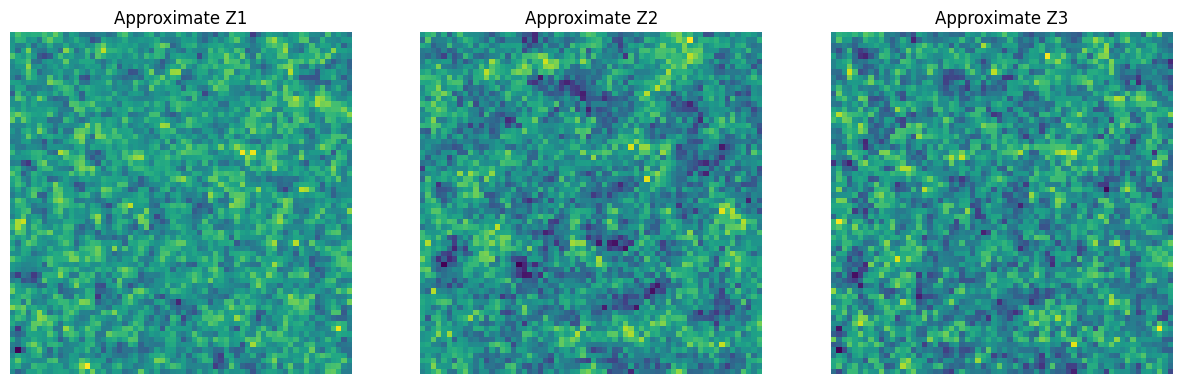

In [105]:
zfig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]
    img = z_inference[i].detach().numpy()
    ax.imshow(img, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Approximate Z{i+1}')

plt.show()

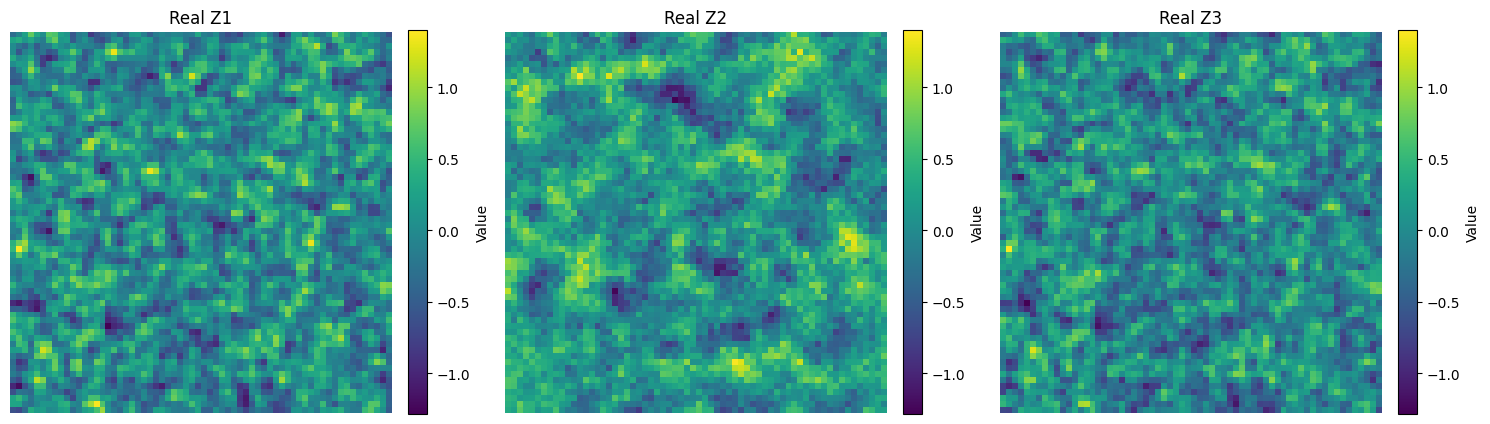

In [17]:
vmin = min(multi_scale_z[0][i].min().item() for i in range(3))
vmax = max(multi_scale_z[0][i].max().item() for i in range(3))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]
    img = multi_scale_z[0][i]
    im = ax.imshow(img, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.imshow(img, cmap='viridis')
    ax.axis('off')
    ax.set_title(f'Real Z{i+1}')

    cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('Value')

plt.tight_layout()
plt.show()

# Save/Load data and model

In [ ]:
# save z1,z2,z3
list_of_z = [z1, z2, z3]
combined_array = np.stack(list_of_z, axis=0)
np.save('real_z1_z2_z3.npy', combined_array)

# save y
list_of_y1 = multi_scale_y_upscale[0]
combined_array = np.stack(list_of_y1, axis=0)
np.save('y1.npy', combined_array)
list_of_y2 = multi_scale_y_upscale[1]
combined_array = np.stack(list_of_y2, axis=0)
np.save('y2.npy', combined_array)
list_of_y3 = multi_scale_y_upscale[2]
combined_array = np.stack(list_of_y3, axis=0)
np.save('y3.npy', combined_array)

In [ ]:
# load z and y
z = np.load('real_z1_z2_z3.npy')
z1 = z[0]
z2 = z[1]
z3 = z[2]
y1 = np.load('y1.npy')
y2 = np.load('y2.npy')
y3 = np.load('y3.npy')
multi_scale_y_upscale = [
    [y1[i] for i in range(y1.shape[0])],
    [y2[i] for i in range(y2.shape[0])],
    [y3[i] for i in range(y3.shape[0])]
]

In [ ]:
def save_model_and_params(score_nets, learnable_params, optimizer, epoch, save_path):

    checkpoint = {
        'epoch': epoch,
        'score_nets_state_dict': [net.state_dict() for net in score_nets],
        'learnable_params_state_dict': learnable_params.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }

    torch.save(checkpoint, save_path)
    print(f"Model and parameters saved to {save_path}")


save_model_and_params(score_nets, learnable_params, optimizer, path_epochs, 'model_checkpoint.pth')

In [ ]:
def load_model_and_params(score_nets, learnable_params, optimizer, load_path):
    checkpoint = torch.load(load_path)

    for net, state_dict in zip(score_nets, checkpoint['score_nets_state_dict']):
        net.load_state_dict(state_dict)

    learnable_params.load_state_dict(checkpoint['learnable_params_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    print(f"Model and parameters loaded from {load_path}, starting from epoch {epoch}")

    return epoch

In [ ]:
# Function to initialize parameters
def initialize_parameter(shape, mean=0.0, std=0.1):
    # Create the tensor and then set requires_grad
    tensor = torch.normal(mean, std, shape)
    tensor = torch.abs(tensor)  # Apply absolute value
    tensor.requires_grad = True  # Enable gradient tracking
    return tensor

# Set initial values using the function
initial_values = {
    'mu': torch.tensor([0.0, 0.0], requires_grad=True),
    'a': torch.tensor([0.33, 0.33, 0.34], requires_grad=True),
    'sigma': initialize_parameter((3,), mean=0.5, std=0.1),
    'omega': initialize_parameter((3,), mean=0.2, std=0.05),
    'nu': initialize_parameter((3,), mean=1.0, std=0.1),
    'theta': initialize_parameter((3, 3, 2)),
    'eta': initialize_parameter((3, 3, 1), mean=0.05, std=0.01)
}

# Ensure 'a' sums to 1
initial_values['a'] = initial_values['a'] / initial_values['a'].sum()

# Clip values to ensure stability
for key in ['sigma', 'omega', 'nu', 'eta']:
    initial_values[key] = torch.clamp(initial_values[key], min=1e-5, max=10)

learnable_params = LearnableParams(initial_values)

score_nets = [ScoreNetZ1(), ScoreNetZ2(), ScoreNetZ3()]

all_params = []
for net in score_nets:
    all_params.extend(net.parameters())
all_params.extend(learnable_params.get_params_list())

optimizer = optim.Adam(all_params, lr=1e-3)


In [ ]:
start_epoch = load_model_and_params(score_nets, learnable_params, optimizer, 'model_checkpoint.pth')